<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/final/Flower4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch

tcmalloc: large alloc 1073750016 bytes == 0x58c0a000 @  0x7ff7d12bb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
# Load data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

print("Data loaded")

Data loaded


In [3]:
# Load train class
!wget -c https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py

import Train

--2018-12-27 13:04:22--  https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107 (13K) [text/plain]
Saving to: ‘Train.py’

Train.py            100%[===================>]  12.80K  --.-KB/s    in 0.005s  

2018-12-27 13:04:22 (2.66 MB/s) - ‘Train.py’ saved [13107/13107]



In [1]:
import Train

# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ceate data loader
train_loader, valid_loader, test_loader = Train.prepare_loader(data_dir,transform_train,transform_valid,test_transforms)

Train size:6552
Valid size:6552
Test size:818


In [2]:
from torchvision import models
# load a pretrained model
model = models.densenet161(pretrained = True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [3]:
from torch import nn
print(model.classifier)
#num_ftrs = model.classifier.in_features
#print(num_ftrs)
#model.classifier = nn.Linear(num_ftrs, 102)
#print(model.classifier)

Linear(in_features=2208, out_features=1000, bias=True)


In [4]:
from collections import OrderedDict
from torch import nn

# create a simple classifier
# 83
classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(2208, 1560)),
                ('fc2', nn.Linear(1560, 1024)),
                ('fc3', nn.Linear(1024, 786)),
                ('fc4', nn.Linear(786, 512)),
                ('relu', nn.ReLU()),
                ('dropout',nn.Dropout(p=0.2)),
                ('fc5', nn.Linear(512, 102)),
                #('fc5', nn.Linear(500, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))

# replace the classifer
model.classifier = classifier
# check the classifier
print(model.classifier)

Sequential(
  (fc1): Linear(in_features=2208, out_features=1560, bias=True)
  (fc2): Linear(in_features=1560, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=786, bias=True)
  (fc4): Linear(in_features=786, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (fc5): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax()
)


In [0]:
import torch
from torch import optim
from torch.optim import lr_scheduler
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [0]:
# Freeze the parameter
model = Train.freeze_parameters(model)
#for _, param in model.named_parameters():
#  param.requires_grad = False
print("Parameter Freezed")

Parameter Freezed


In [12]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
model_save_name = 'flower4_27_1a_93.pt'
path = F"/content/gdrive/My Drive/model/{model_save_name}"
model.load_state_dict(torch.load(path))
print("Model loaded")

Model loaded


In [0]:
# Train model
epochs = 5
model, train_loss,valid_loss = Train.train_model(
    model,train_loader,valid_loader, epochs, optimizer,scheduler, criterion)

Epoch: 1/5
		Going for validation
	Train loss:1.221859.. 	Valid Loss:0.168148.. 	Accuracy: 77.4046
	Validation loss decreased (inf --> 0.168148).  Saving model ...
	Epoch:1 completed in 4m 28s
Epoch: 2/5
		Going for validation
	Train loss:1.029103.. 	Valid Loss:0.129079.. 	Accuracy: 81.0687
	Validation loss decreased (0.168148 --> 0.129079).  Saving model ...
	Epoch:2 completed in 4m 27s
Epoch: 3/5
		Going for validation
	Train loss:0.543967.. 	Valid Loss:0.049215.. 	Accuracy: 92.3664
	Validation loss decreased (0.129079 --> 0.049215).  Saving model ...
	Epoch:3 completed in 4m 25s
Epoch: 4/5
		Going for validation
	Train loss:0.455482.. 	Valid Loss:0.045878.. 	Accuracy: 92.5954
	Validation loss decreased (0.049215 --> 0.045878).  Saving model ...
	Epoch:4 completed in 4m 25s
Epoch: 5/5
		Going for validation
	Train loss:0.413273.. 	Valid Loss:0.044018.. 	Accuracy: 93.5115
	Validation loss decreased (0.045878 --> 0.044018).  Saving model ...
	Epoch:5 completed in 4m 25s
Training comple

In [0]:
model.load_state_dict(torch.load("model.pt"))

In [0]:
torch.save(model.state_dict(), "model93.pt")

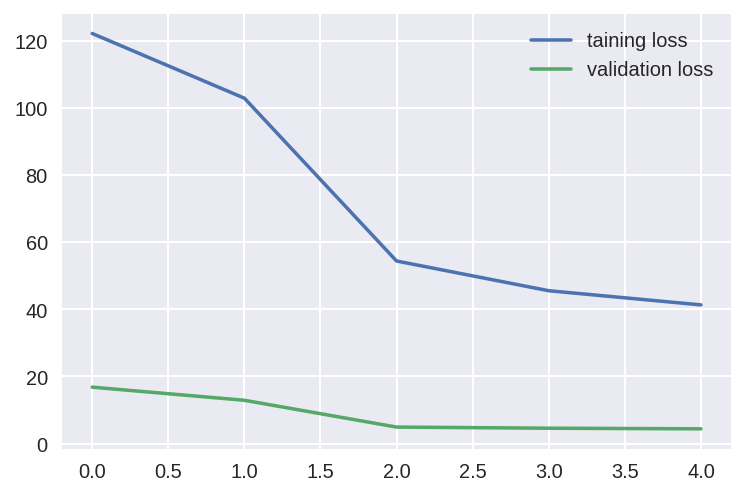

In [0]:
#Check for overfitting

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_loss, label = "taining loss")
plt.plot(valid_loss, label = "validation loss")
plt.legend(frameon = False)

In [0]:
!ls /content/gdrive/My Drive/model

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/model': No such file or directory


In [0]:
# type day_time_pm_percentage
model_save_name = 'flower4_27_1a_93.pt'
path = F"/content/gdrive/My Drive/model/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
# Unfreeze the parameter
model = Train.unfreeze(model)
#for _, param in model.named_parameters():
#  param.requires_grad = True

print("Parameter unfreezed")

Parameter unfreezed


In [7]:
# Test accuracy top 10 classs
Train.calculate_top_accuracy(model, test_loader, criterion)

Test Loss: 0.013903

Test Accuracy of     0: 100% ( 3/ 3)
Test Accuracy of     1: 100% ( 3/ 3)
Test Accuracy of     2: 75% ( 3/ 4)
Test Accuracy of     3: 100% ( 2/ 2)
Test Accuracy of     4: 100% ( 4/ 4)
Test Accuracy of     5: 66% ( 2/ 3)
Test Accuracy of     6: 100% ( 2/ 2)
Test Accuracy of     7: 100% ( 4/ 4)
Test Accuracy of     8:  0% ( 0/ 1)
Test Accuracy of     9: 100% ( 4/ 4)

Test Accuracy (Overall): 91% (377/410)


In [8]:
# Test total accuracy
Train.calc_accuracy(model,testset_path="flower_data/valid",batch_size=batch_size)

Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.8333333134651184
Mean accuracy: 0.9238782525062561


0.92387825

In [9]:
# Test with google data set
Train.calc_accuracy(model,use_google_testset=True,batch_size=batch_size)

100.0% 292610048 / 292604296


Batch accuracy (Size 32): 0.625
Batch accuracy (Size 32): 0.5625
Batch accuracy (Size 32): 0.53125
Batch accuracy (Size 32): 0.53125
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.5625
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.4375
Batch accuracy (Size 32): 0.40625
Batch accuracy (Size 32): 0.71875
Batch accuracy (Size 32): 0.6875
Batch accuracy (Size 32): 0.53125
Batch accuracy (Size 32): 0.46875
Batch accuracy (Size 32): 0.5
Batch accuracy (Size 32): 0.5
Batch accuracy (Size 32): 0.46875
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.4375
Batch accuracy (Size 32): 0.4375
Batch accuracy (Size 32): 0.5
Batch accuracy (Size 32): 0.5
Batch accuracy (Size 32): 0.53125
Batch accuracy (Size 32): 0.40625
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.5
Batch accuracy (Size 32): 0.59375
Batch accuracy (Size 32): 0.5625
Batch accuracy (Size 32): 0.59375
Batch acc

0.5364118

In [0]:
cat_to_name = Train.get_cat_name()

In [0]:
# visualize data